In [13]:
import pandas as pd

df_main = pd.read_csv(r'C:\work\DrugDiscovery\main_git\XAI_Chem\data\init_data\pKa_Prediction_Starting data_2024.01.25.csv', index_col=0)

df_oos = pd.read_csv(r'C:\work\DrugDiscovery\main_git\XAI_Chem\data\logP_lipophilicity_data\gnn_cv\test.csv', index_col=0)

In [14]:
SMILES_to_fgroup = {}
SMILES_to_identificator = {}
for index, row in df_main.iterrows():
    SMILES = row['Amides for LogP']
    if pd.isnull(SMILES):
        continue
    
    SMILES_to_fgroup[SMILES] = row['F group']
    SMILES_to_identificator[SMILES] = row['identificator']


In [75]:
from rdkit import Chem

functional_group_to_smiles = {
    "CF3": "C(F)(F)F", 
    "CH2F": "CCF", 
    "gem-CF2": "F", 
    "CHF2": "C(F)(F)",
    "CHF": "CF",
    "non-F": ""
}

logP_ring = 'C1=CC=CC=C1'
mol_ring = Chem.MolFromSmiles(logP_ring)

for index, row in df_oos.iterrows():
    logP_SMILES = row['Smiles']

    # if logP_SMILES != "[H]C(F)(F)C1CCN(CC1)C(=O)C1=CC=CC=C1": continue
    
    identificator = SMILES_to_identificator[logP_SMILES]
    f_group = SMILES_to_fgroup[logP_SMILES]

    molecule = Chem.MolFromSmiles(logP_SMILES)
    # ADDITIONAL LOGP RING MATCHES
    mol_ring_matches = molecule.GetSubstructMatches(mol_ring)
    if not molecule.HasSubstructMatch(mol_ring):
        print(logP_SMILES)

    for match in mol_ring_matches:
        for atom_idx in match:
            atom = molecule.GetAtomWithIdx(atom_idx)
            atom.SetProp('atomNote', 'logP_ring')

    # COOH MATCHES
    NCOOH_SMILE = 'NC(=O)'
    if "secondary" in identificator.lower():
        NCOOH_SMILE = 'C(=O)'
    ncooh_mol = Chem.MolFromSmiles(NCOOH_SMILE)
    ncooh_matches = molecule.GetSubstructMatches(ncooh_mol)
    if not molecule.HasSubstructMatch(ncooh_mol):
        print(logP_SMILES)

    for match in ncooh_matches:
        for atom_idx in match:
            atom = molecule.GetAtomWithIdx(atom_idx)
            atom.SetProp('atomNote', 'COOH')

    # FLUORIC GROUP MATCHES
    f_group_smiles = functional_group_to_smiles[f_group]
    f_group_mol = Chem.MolFromSmiles(f_group_smiles)
    f_group_matches = molecule.GetSubstructMatches(f_group_mol)
    if not molecule.HasSubstructMatch(f_group_mol) and f_group != "non-F":
        print(f_group, logP_SMILES)

    for match in f_group_matches:
        for atom_idx in match:
            atom = molecule.GetAtomWithIdx(atom_idx)
            atom.SetProp('atomNote', 'F group')

    matches = [list(match) for match in mol_ring_matches] + [list(match) for match in ncooh_matches] + [list(match) for match in f_group_matches]
    all_indices = set()
    for indices in matches:
        all_indices.update(indices)

    # MAIN MOLECULE PART ATOMS
    main_molecule_atoms = []
    for atom in molecule.GetAtoms():
        atom_index = atom.GetIdx()
        if atom_index not in all_indices:
            main_molecule_atoms.append(atom_index)
    all_indices.update(main_molecule_atoms)
    for atom_idx in main_molecule_atoms:
        atom = molecule.GetAtomWithIdx(atom_idx)
        atom.SetProp('atomNote', 'MM')
    matches += [main_molecule_atoms]
    
    print(identificator, logP_SMILES, mol_ring_matches, ncooh_matches, f_group_matches, f_group)
    print(matches)

Primary amine O=C(NC1CCC1)C1=CC=CC=C1 ((7, 8, 9, 10, 11, 12),) ((2, 1, 0),) () non-F
[[7, 8, 9, 10, 11, 12], [2, 1, 0], [3, 4, 5, 6]]
Carboxylic acid FC1(F)CC1C(=O)NC1=CC=CC=C1 ((8, 9, 10, 11, 12, 13),) ((7, 5, 6),) ((0,), (2,)) gem-CF2
[[8, 9, 10, 11, 12, 13], [7, 5, 6], [0], [2], [1, 3, 4]]
Carboxylic acid FC1(F)CC2(CC(C2)C(=O)NC2=CC=CC=C2)C1 ((11, 12, 13, 14, 15, 16),) ((10, 8, 9),) ((0,), (2,)) gem-CF2
[[11, 12, 13, 14, 15, 16], [10, 8, 9], [0], [2], [1, 3, 4, 5, 6, 7, 17]]
Secondary amine FC1CCN(CC1)C(=O)C1=CC=CC=C1 ((9, 10, 11, 12, 13, 14),) ((7, 8),) ((1, 0),) CHF
[[9, 10, 11, 12, 13, 14], [7, 8], [1, 0], [2, 3, 4, 5, 6]]
Carboxylic acid FC1(F)CCC(CC1)C(=O)NC1=CC=CC=C1 ((11, 12, 13, 14, 15, 16),) ((10, 8, 9),) ((0,), (2,)) gem-CF2
[[11, 12, 13, 14, 15, 16], [10, 8, 9], [0], [2], [1, 3, 4, 5, 6, 7]]
Primary amine [H]C(F)(F)[C@@H]1CC[C@H]1NC(=O)C1=CC=CC=C1 ((10, 11, 12, 13, 14, 15),) ((7, 8, 9),) ((0, 1, 2),) CHF2
[[10, 11, 12, 13, 14, 15], [7, 8, 9], [0, 1, 2], [3, 4, 5, 6]]
Carb

In [38]:
molecule

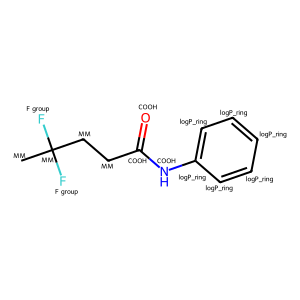

In [74]:
from rdkit.Chem import Draw

img = Draw.MolToImage(molecule)

img